In [1]:
# Imports here
import torch
import torch.nn as nn
from torch.nn import Sequential
from torchvision import models,transforms
from torchvision import datasets
import json
from torchvision import datasets,models
from torch import optim
from workspace_utils import active_session
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt



In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)



In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
# TODO: Build and train your network
from torchvision import datasets,models

model = models.vgg11(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False

In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [7]:
from torch import optim
from torch.nn import Sequential
from torch import nn

In [8]:
model.classifier = Sequential(nn.Linear(25088,4096),
                              nn.ReLU(),
                              nn.Dropout(0.01),
                              nn.Linear(4096,102),
                              nn.LogSoftmax(dim=1))



criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.003)


In [9]:
from workspace_utils import active_session

In [10]:
torch.cuda.is_available()

True

In [11]:

with active_session():
    model = model.cuda()
    epochs = 20

    train_losses,test_losses = [],[]

    for epoch in range(epochs):
        running_loss = 0
        for images,labels in trainloader:
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
            loss = criterion(output,labels)
            running_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        else:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images,labels in validloader:
                    images = images.cuda()
                    labels = labels.cuda()
                    output = model(images)
                    loss = criterion(output,labels)
                    test_loss += loss.item()
                    ps = torch.exp(output)
                    top_v,top_class = ps.topk(1,dim=1)
                    result = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(result.type(torch.FloatTensor)).item()
            test_losses.append(test_loss)
            train_losses.append(running_loss)
            model.train()

            print(f"Epoch: {epoch+1}/{epochs}",
                   "test loss: ",test_loss/len(validloader),
                   "train loss: ",running_loss/len(validloader),
                   "accuracy: ",accuracy/len(validloader))


Epoch: 1/20 test loss:  1.040470336492245 train loss:  30.909112939467796 accuracy:  0.729375000183399
Epoch: 2/20 test loss:  0.8498234955164102 train loss:  10.932857481332926 accuracy:  0.7859615362607516
Epoch: 3/20 test loss:  0.8023903645001925 train loss:  9.569760450950035 accuracy:  0.8025961518287659
Epoch: 4/20 test loss:  0.7954059552687865 train loss:  8.493054055250608 accuracy:  0.8196153824145977
Epoch: 10/20 test loss:  0.8180982937606481 train loss:  8.087264647850624 accuracy:  0.85567307472229
Epoch: 11/20 test loss:  0.8483925776985975 train loss:  7.497507494229537 accuracy:  0.8399038452368516
Epoch: 12/20 test loss:  0.9214137058991653 train loss:  7.450920228774731 accuracy:  0.853413462638855
Epoch: 13/20 test loss:  0.9014056118635031 train loss:  7.186113346081513 accuracy:  0.8611538456036494
Epoch: 14/20 test loss:  0.8412094162060664 train loss:  7.745087465414634 accuracy:  0.8598076930412879
Epoch: 15/20 test loss:  0.8741007401393011 train loss:  7.248

In [44]:

test_loss = 0
accuracy = 0
#criterion = nn.NLLLoss()
#optimizer = optim.Adam(model.classifier.parameters(),lr=0.003)
model.cuda()
model.eval()
with torch.no_grad():
    for images,labels in testloader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        test_loss += loss.item()
        ps = torch.exp(output)
        top_v,top_class = ps.topk(1,dim=1)
        result = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(result.type(torch.FloatTensor)).item()
    else:
        #test_losses.append(test_loss)
        #train_losses.append(running_loss)
        model.train()
        print("accuracy: ",accuracy/len(testloader),
              "test loss",test_loss/len(testloader))

accuracy:  0.8430901215626643 test loss 1.0185970320151403


In [27]:


checkpoint = {'class_to_idx': train_data.class_to_idx,
              'state_dict': model.state_dict(),
              'classifier': model.classifier,
              'optimizer_state_dict': optimizer.state_dict,
              'epochs': 20}

torch.save(checkpoint, 'checkpoint.pth')



In [41]:
def load_modelvgg11(check):
    
    checkpoint = torch.load(check)
    model = models.vgg11(pretrained=True);
    
    for param in model.parameters():
        param.requires_grad = False
   
    model.classifier = checkpoint['classifier'] 
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [42]:
model = load_modelvgg11('checkpoint.pth')

In [43]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [45]:
from PIL import Image
import numpy as np
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
    im = Image.open(image)
    im = valid_transforms(im)
    #im = im.transpose()
    
    return im

    
    
    

In [46]:
import matplotlib.pyplot as plt

image = 'flowers/train/56/image_02827.jpg'
im = process_image(image)
print(im.shape)

torch.Size([3, 224, 224])


In [47]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

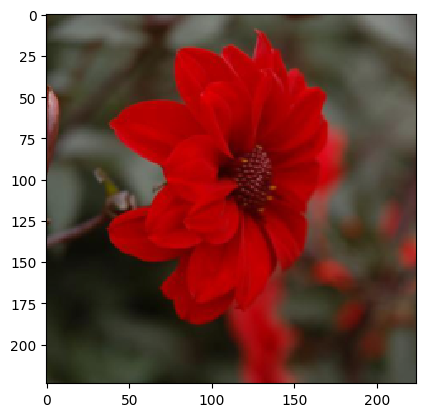

In [48]:
imshow(im)

In [49]:
type(model.class_to_idx)

dict

In [50]:
model.class_to_idx[str(1)]

0

In [51]:
from PIL import Image
def predict(image_path, model, topk=5):
    
   
    model.eval()
    im = process_image(image_path)
    im = im.unsqueeze(0)
    im = im.float()
    im = im.cuda()
    
    with torch.no_grad():
        log_ps = model.forward(im)
        ps = torch.exp(log_ps)
        top_ps,top_class = ps.topk(topk,dim=1)
        top_cl = []
    
    for i in list(np.array(top_class.view(-1))):
        for k,v in model.class_to_idx.items():
            if i == v:
                top_cl.append(k)
        
    return list(np.array(top_ps.view(-1))),top_cl   
    #return list(np.array(top_ps)), top_cl 


    


In [52]:
image_path = 'flowers/test/23/image_03409.jpg'
im =process_image(image_path)

probabilities, classes = predict(image_path, model)
    
print(probabilities)
print(classes)

[1.0, 1.1049599e-35, 9.0874205e-42, 1.7446166e-42, 2.1720126e-43]
['23', '88', '40', '102', '16']


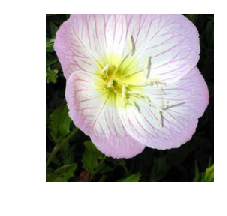

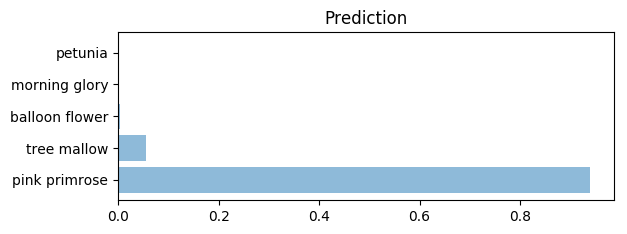

In [53]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


path = test_dir + '/1/image_06743.jpg'
image = process_image(path)
plt.subplot(2, 1, 1)
axs = imshow(image, ax = plt)
axs.axis('off')
axs.show()

probabilities,classes = predict(path,model)
class_name = []

for i in classes:
    class_name.append(cat_to_name[str(i)])

plt.subplot(2, 1, 2)
y_pos = np.arange(len(class_name))
plt.barh(y_pos, probabilities, align='center', alpha=0.5)
plt.yticks(y_pos, class_name)
plt.title('Prediction')
 
plt.show()

